# Logistic Regression, Bayes and EM

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# not my function*
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('data/training_set.csv')
test_set = pd.read_csv('data/test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
first graph first feature, first 1000 datapoints
second graph first feature, all data points
third graph both features first 1000 datapoints
fourth graph both features all datapoints

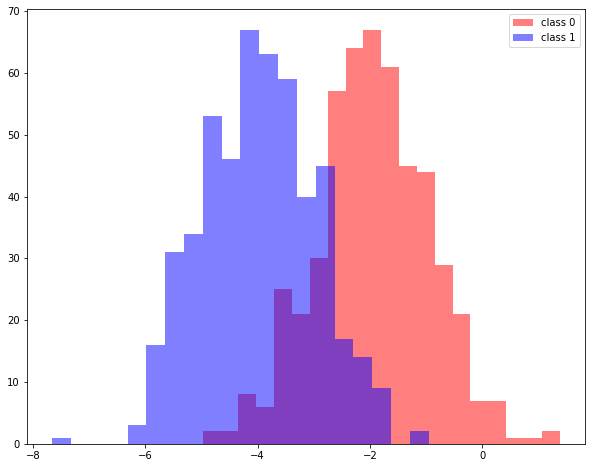

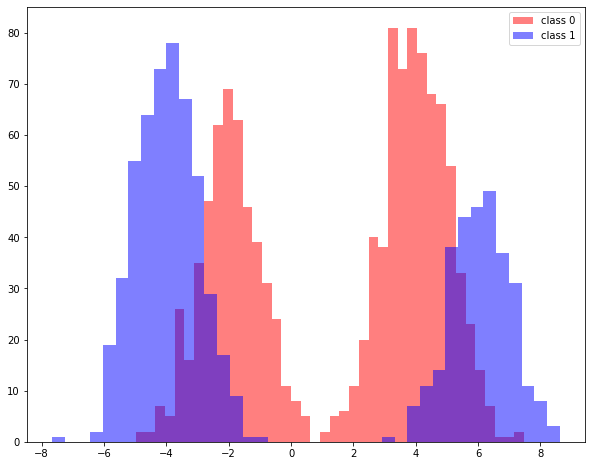

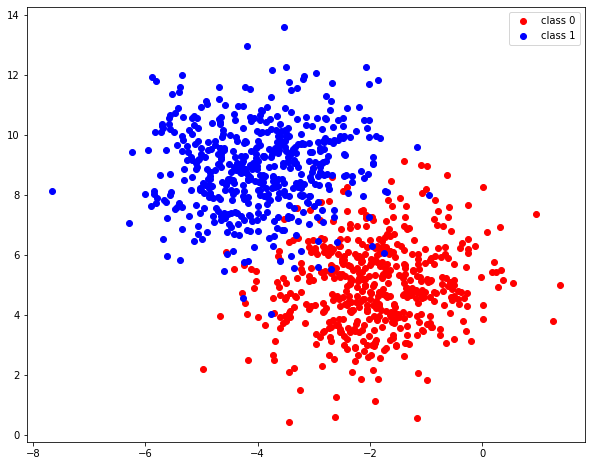

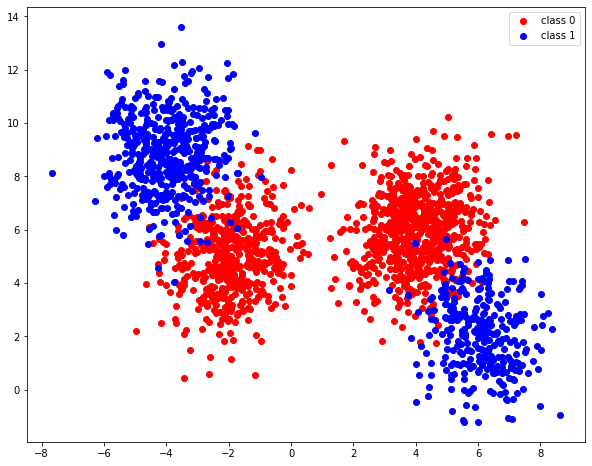

In [5]:
#first feature
#first 1000
first_1000 = training_set[0:1000]
class0_data_f = first_1000[first_1000['y'] == 0] 
class1_data_f = first_1000[first_1000['y'] == 1]
feat0_class0_f = class0_data_f.iloc[:,0]
feat0_class1_f = class1_data_f.iloc[:,0]
plt.hist(feat0_class0_f, bins = 20, alpha = 0.5, color = 'r')
plt.hist(feat0_class1_f, bins = 20, alpha = 0.5, color = 'b')
plt.legend(['class 0', 'class 1'])
plt.show()

#all data points
class0_data_a = training_set[training_set['y'] == 0] 
class1_data_a = training_set[training_set['y'] == 1]
feat0_class0_a = class0_data_a.iloc[:,0]
feat0_class1_a = class1_data_a.iloc[:,0]
plt.hist(feat0_class0_a, bins = 40, alpha = 0.5, color = 'r')
plt.hist(feat0_class1_a, bins = 40, alpha = 0.5, color = 'b')
plt.legend(['class 0', 'class 1'])
plt.show()

#both features
#first 1000
feat1_class0_f = class0_data_f.iloc[:,1]
feat1_class1_f = class1_data_f.iloc[:,1]
plt.scatter(feat0_class0_f, feat1_class0_f, color = 'r')
plt.scatter(feat0_class1_f, feat1_class1_f, color = 'b')
plt.legend(['class 0', 'class 1'])
plt.show()

#all data points
feat1_class0_a = class0_data_a.iloc[:,1]
feat1_class1_a = class1_data_a.iloc[:,1]
plt.scatter(feat0_class0_a, feat1_class0_a, color = 'r')
plt.scatter(feat0_class1_a, feat1_class1_a, color = 'b')
plt.legend(['class 0', 'class 1'])
plt.show()

## Logistic Regression

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    ##consider adding bias to dataset and to theta
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = np.ones(3)  ##was NULL
        self.Jhistory = []
        
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        X = np.c_[np.ones(X.shape[0]), X]
        theta = np.random.rand(X.shape[1])
        self.theta = theta
        for i in range(self.n_iter):
            cost_deriv = (self.hypothesis(X) - y).T.dot(X)
            self.theta = self.theta - (self.eta * cost_deriv)
            self.Jhistory.append(self.compute_cost(X,y))
            if (i > 0) and ((self.Jhistory[i-1] - self.Jhistory[i]) < self.eps):
                break
        pass
    
    def predict(self, X):
        """Return the predicted class label"""
        X = np.c_[np.ones(X.shape[0]), X]
        return np.round(self.hypothesis(X))
        pass

    def compute_cost(self, X, y):
        
        m = X.shape[0]
        hypo = self.hypothesis(X)
        inner = (-1 * y).dot(np.log(hypo)) - (1 - y).dot(np.log(1 - hypo))
        return inner / m
    
    def hypothesis(self, X):
        
        e_pow = np.e**(-1 * (X.dot(self.theta)))
        denominator = 1 + e_pow
        return (1 / denominator)
        

## Cross Validation
This may take a few minutes

In [7]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
data = training_set.values.copy()
fold = 5
np.random.shuffle(data)
nolab_data = np.delete(data,-1,1)
labels = data.T[-1]
X = np.array_split(nolab_data,fold)
y = np.array_split(labels,fold)

result_x = np.arange(len(etas) * len(epss)).reshape(len(etas),len(epss)).astype(float)

for t in range(len(etas)):
    for e in range(len(epss)):
        accuracy_sum = 0
        for i in range(fold):
            training_group = X.copy()
            test_group = training_group[i]
            training_group.pop(i)
            training_y = y.copy()
            test_y = training_y[i]
            training_y.pop(i)
            
            training_group_flat = training_group[0]
            training_y_flat = training_y[0]
            for j in range(len(training_group) - 1):
                training_group_flat = np.vstack((training_group_flat,training_group[j+1]))
                training_y_flat = np.append(training_y_flat,training_y[j+1])
            
            model_obj = LogisticRegressionGD(eta = etas[t], n_iter = 10000 ,eps = epss[e], random_state = 1)
            model_obj.fit(training_group_flat, training_y_flat)
            
            pred_vec = model_obj.predict(test_group)
            acc_vec = test_y - pred_vec
            accuracy_sum += np.count_nonzero(acc_vec == 0) / len(acc_vec)
        
        result_x[t][e] = accuracy_sum / fold

best_row_acc = 0
best_eta_index = 0
best_eps_index = 0

for i in range(len(result_x)):
    if max(result_x[i]) > best_row_acc:
        best_eps_index = np.argmax(result_x[i])
        best_eta_index = i
        best_row_acc = max(result_x[i])

print(result_x)
best_eta = etas[best_eta_index]
best_eps = epss[best_eps_index]
print(f"The best eta is {best_eta}")
print(f"The best epsilon is {best_eps}")


[[0.4805 0.4805 0.4805 0.4805 0.4805]
 [0.559  0.559  0.559  0.559  0.559 ]
 [0.3555 0.3555 0.3555 0.3555 0.3555]
 [0.4965 0.556  0.568  0.69   0.7965]
 [0.397  0.494  0.5465 0.568  0.6895]]
The best eta is 5e-05
The best epsilon is 1e-06


## Normal distribution pdf

In [8]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    body = e** (-0.5 * (((data - mu)/sigma)**2))
    return coef * body

## Expectation Maximization

In [9]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.w_vec = None
        self.mean_vec = None
        self.std_vec = None
        self.Jhistory = None
        

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        new_data = np.array_split(data,self.k)
        self.w_vec = []
        self.mean_vec = []
        self.std_vec = []
        for i in range(self.k):
            self.w_vec.append(1 / self.k)
            self.mean_vec.append(np.mean(new_data[i]))
            self.std_vec.append(np.std(new_data[i]))
        self.w_vec = np.array(self.w_vec)
        self.mean_vec = np.array(self.mean_vec)
        self.std_vec = np.array(self.std_vec)
        
        pass
    
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        respsnum = []
        for i in range(self.k):
            respsnum.append(self.w_vec[i]*norm_pdf(data, self.mean_vec[i], self.std_vec[i]))
        respsnum = np.array(respsnum)
        denominator = respsnum.T.dot(np.ones(self.k))
        return (respsnum / denominator).T
        
        pass

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        #newW
        coef = 1 / data.shape[0]
        body = self.expectation(data)
        self.w_vec = (body * coef).sum(axis=0)
        
        #newMu
        coef = 1 / (data.shape[0] * self.w_vec)
        datacopy = data.copy()
        body = self.expectation(data).T.dot(data)
        self.mean_vec = (body * coef)
        
        #newSigma
        body = self.expectation(data)
        for i in range(self.k - 1):              #expand width of data for linear algebra considerations
            datacopy = np.c_[datacopy,data]
        sub_sq = (datacopy - self.mean_vec)**2
        self.std_vec = np.sqrt(coef.dot(body.T.dot(sub_sq))) * np.ones(self.k)
        pass
    

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.Jhistory = []
        for i in range(self.n_iter):
            self.maximization(data)
            self.Jhistory.append(self.compute_cost(data))
            if (i > 0) and (self.Jhistory[i-1] - self.Jhistory[i]) < self.eps:
                break
        pass

    def get_dist_params(self):
        
        return self.w_vec, self.mean_vec, self.std_vec
        pass
    
    def compute_cost(self,data):
        datacopy = data.copy()
        for i in range(self.k - 1):
            datacopy = np.c_[datacopy,data]
        if self.k == 1: cost = -1 * np.log(self.w_vec * (norm_pdf(datacopy, self.mean_vec, self.std_vec)))
        else: cost = -1 * np.log(self.w_vec.dot(norm_pdf(datacopy, self.mean_vec, self.std_vec).T))
        return np.sum(cost)

## Naive Bayes

In [10]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    def __init__(self, k=1):
        self.k = k
        self.gmms_X0 = None
        self.gmms_X1 = None
        self.priorX0 = 0
        self.priorX1 = 0


    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        X0 = np.ones(X.shape[1])
        X1 = np.ones(X.shape[1])
        for ins in range(X.shape[0]):
            if y[ins] == 0:
                X0 = np.vstack((X0,X[ins]))
            else:
                X1 = np.vstack((X1,X[ins]))
        X0 = np.delete(X0,0,0)
        X1 = np.delete(X1,0,0)
        
        self.priorX0 = len(X0) / len(X)
        self.priorX1 = len(X1) / len(X)
        
        em_obj = EM(self.k)
        self.gmms_X0 = []
        self.gmms_X1 = []
        
        for feat in X0.T:
            em_obj.fit(feat)
            self.gmms_X0.append(em_obj.get_dist_params())
            
        for feat in X1.T:
            em_obj.fit(feat)
            self.gmms_X1.append(em_obj.get_dist_params())

        pass
    
    def predict(self, X):
        """Return the predicted class label"""
        X0 = np.ones(X.shape[0]) * self.priorX0
        X1 = np.ones(X.shape[0]) * self.priorX1
        i = 0
        for feat in X.T:
            for j in range(self.k):
                X0 = X0 * self.gmms_X0[i][0][j] * (norm_pdf(feat, self.gmms_X0[i][1][j], self.gmms_X0[i][2][j]))
            i +=1
        i=0
        for feat in X.T:
            for j in range(self.k):
                X1 = X1 * self.gmms_X1[i][0][j] * (norm_pdf(feat, self.gmms_X1[i][1][j], self.gmms_X1[i][2][j]))
            i +=1
        
        res = X1-X0
        res = np.where(res < 0, 0, 1)
        return res


## Model evaluation

training accuracy of logistic regression on first 1000 points : 0.965
testing accuracy of logistic regression on first 500 points : 0.938
training accuracy of naiveBayes on first 1000 points : 0.967
testing accuracy of naiveBayes on first 500 points : 0.942


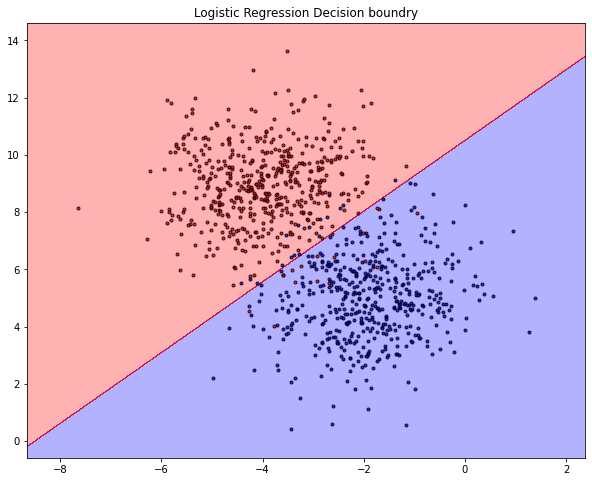

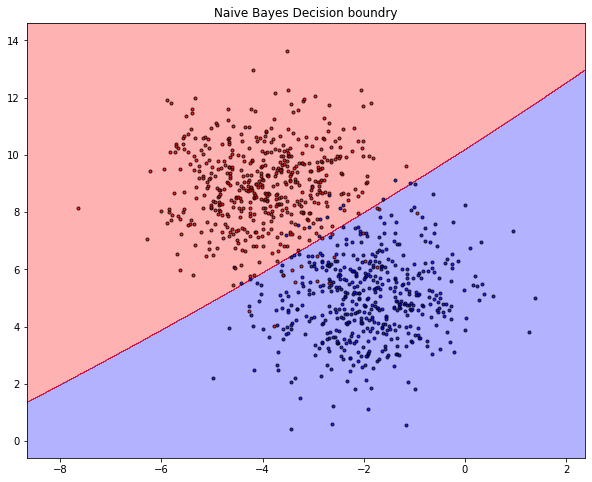

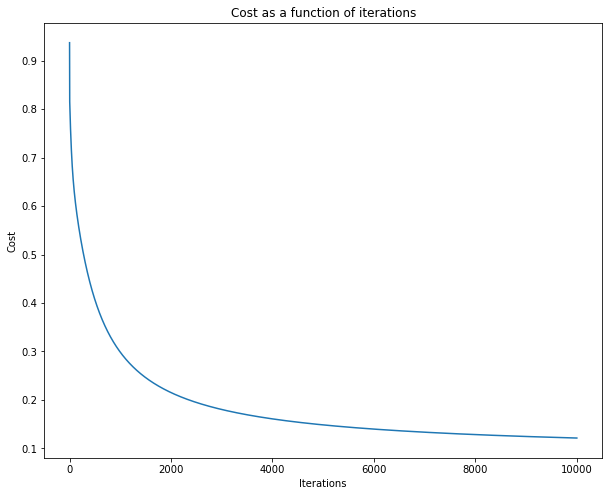

training accuracy of logistic regression on all points : 0.809
testing accuracy of logistic regression on all points : 0.804
training accuracy of naiveBayes on all points : 0.8575
testing accuracy of naiveBayes on all points : 0.856


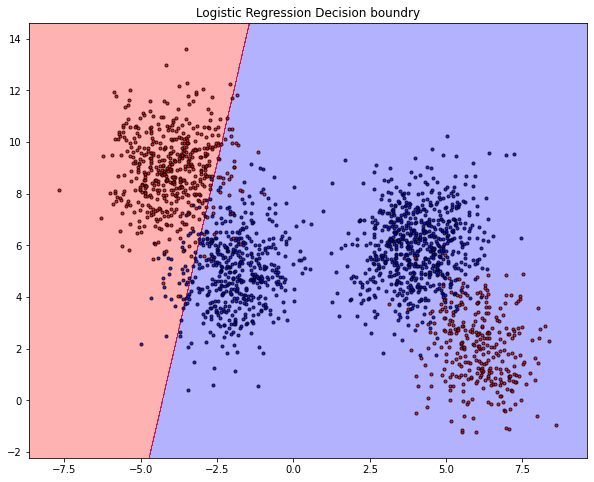

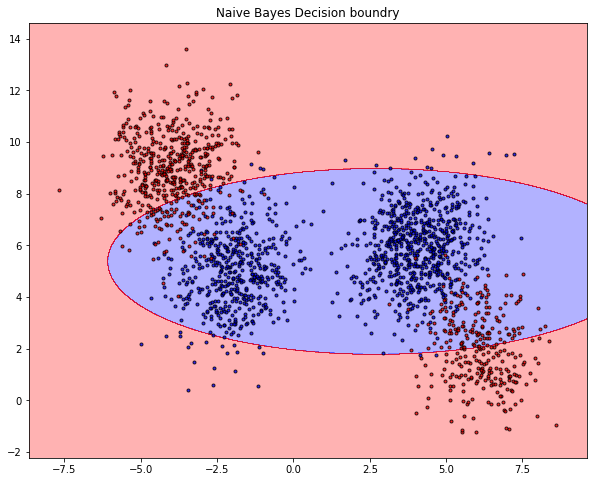

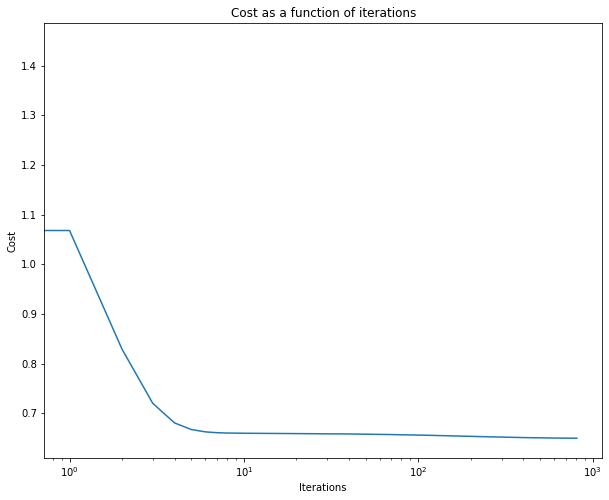

In [11]:
def compute_accuracy(X,y):
    count = 0
    for i in range(len(X)):
        if X[i] == y[i]: count +=1
    return count / len(X)
    
    
#first1000
first_1000_train = first_1000.values
first_500_test = test_set[0:500].values
log_reg = LogisticRegressionGD(eta = best_eta, n_iter=10000, eps = best_eps)
NB = NaiveBayesGaussian(k=2)
first_1000_train_y = first_1000_train.T[-1]
first_1000_train_X = first_1000_train[:,:-1]
first_500_test_y = first_500_test.T[-1]
first_500_test_X = first_500_test[:,:-1]
log_reg.fit(first_1000_train_X, first_1000_train_y)
NB.fit(first_1000_train_X, first_1000_train_y)

first_1000_lg_prediction_train = log_reg.predict(first_1000_train_X)
print(f"training accuracy of logistic regression on first 1000 points : {compute_accuracy(first_1000_lg_prediction_train, first_1000_train_y)}")
first_500_lg_prediction_test = log_reg.predict(first_500_test_X)
print(f"testing accuracy of logistic regression on first 500 points : {compute_accuracy(first_500_lg_prediction_test, first_500_test_y)}")

first_1000_nb_prediction_train = NB.predict(first_1000_train_X)
print(f"training accuracy of naiveBayes on first 1000 points : {compute_accuracy(first_1000_nb_prediction_train, first_1000_train_y)}")
first_500_nb_prediction_test = NB.predict(first_500_test_X)
print(f"testing accuracy of naiveBayes on first 500 points : {compute_accuracy(first_500_nb_prediction_test, first_500_test_y)}")

#plots
plot_decision_regions(first_1000_train_X, first_1000_train_y, log_reg)
plt.title('Logistic Regression Decision boundry')
plt.show()
plot_decision_regions(first_1000_train_X, first_1000_train_y, NB)
plt.title('Naive Bayes Decision boundry')
plt.show()

plt.plot(np.arange(log_reg.n_iter), log_reg.Jhistory)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations')
plt.show()

#allpoints
all_train = training_set.values
all_test = test_set.values
log_reg = LogisticRegressionGD(eta = best_eta, n_iter=10000, eps = best_eps)
NB = NaiveBayesGaussian(k=2) #note k=5 for reference to k=2 question
all_train_y = all_train.T[-1]
all_train_X = all_train[:,:-1]
all_test_y = all_test.T[-1]
all_test_X = all_test[:,:-1]
log_reg.fit(all_train_X, all_train_y)
NB.fit(all_train_X, all_train_y)

all_lg_prediction_train = log_reg.predict(all_train_X)
print(f"training accuracy of logistic regression on all points : {compute_accuracy(all_lg_prediction_train, all_train_y)}")
all_lg_prediction_test = log_reg.predict(all_test_X)
print(f"testing accuracy of logistic regression on all points : {compute_accuracy(all_lg_prediction_test, all_test_y)}")

all_nb_prediction_train = NB.predict(all_train_X)
print(f"training accuracy of naiveBayes on all points : {compute_accuracy(all_nb_prediction_train, all_train_y)}")
all_nb_prediction_test = NB.predict(all_test_X)
print(f"testing accuracy of naiveBayes on all points : {compute_accuracy(all_nb_prediction_test, all_test_y)}")

#plots
plot_decision_regions(all_train_X, all_train_y, log_reg)
plt.title('Logistic Regression Decision boundry')
plt.show()
plot_decision_regions(all_train_X, all_train_y, NB)
plt.title('Naive Bayes Decision boundry')
plt.show()

plt.plot(np.arange(len(log_reg.Jhistory)), log_reg.Jhistory)
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations')
plt.show()

## Naive Bayes vs Log reg
Exploring different datasets where NB/Log reg are better than one another

accuracy of naive bayes on dataset (this is as training accuracy):  0.99
accuracy of logistic regression on dataset (this is as training accuracy):  0.3475
Naive Bayes is better visualization below


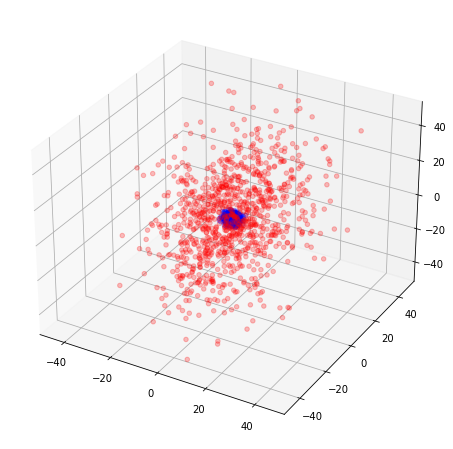

accuracy of naive bayes on dataset (this is as training accuracy):  0.5
accuracy of logistic regression on dataset (this is as training accuracy):  0.933
Log Reg is better visualization below


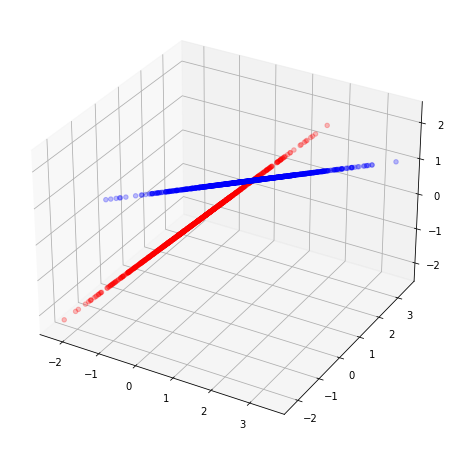

In [14]:
from scipy.stats import multivariate_normal
data_set_size = 1000

#generating dataset A
af1,af2,af3 = np.random.multivariate_normal([1,1,1],[[2,0,0],[0,2,0],[0,0,2]],data_set_size).T
af_1,af_2,af_3 = np.random.multivariate_normal([1,1,1],[[200,0,0],[0,200,0],[0,0,200]],data_set_size).T

afirst_half = np.c_[af1, af2, af3]
asecond_half = np.c_[af_1, af_2, af_3]
afull_data = np.vstack((afirst_half, asecond_half))
alabels = np.concatenate((np.zeros(data_set_size), np.ones(data_set_size)))
#dataset generated

#train the models and print results
aNB = NaiveBayesGaussian(k=2)
aNB.fit(afull_data, alabels)
apredn = aNB.predict(afull_data)
print(f"accuracy of naive bayes on dataset (this is as training accuracy): ",compute_accuracy(apredn,alabels))
alog_reg = LogisticRegressionGD(eta = best_eta, n_iter=10000, eps = best_eps)
alog_reg.fit(afull_data, alabels)
apredl = alog_reg.predict(afull_data)
print(f"accuracy of logistic regression on dataset (this is as training accuracy): ",compute_accuracy(apredl,alabels))

#visualization
print("Naive Bayes is better visualization below")
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
alpha = 0.25
ax.scatter(af_1, af_2, af_2, color='r', alpha=alpha)
ax.scatter(af1, af2, af3, color='b', alpha=alpha)
plt.show()

#B
#generating dataset B
bf1,bf2,bf3 = np.random.multivariate_normal([1,1,1],[[0.5,0.5,0],[0.5,0.5,0],[0.5,0.5,0]],data_set_size).T
bf_1,bf_2,bf_3 = np.random.multivariate_normal([0,0,0],[[0.5,0.5,0.5],[0.5,0.5,0.5],[0.5,0.5,0.5]],data_set_size).T

bfirst_half = np.c_[bf1, bf2, bf3]
bsecond_half = np.c_[bf_1, bf_2, bf_3]
bfull_data = np.vstack((bfirst_half, bsecond_half))
blabels = np.concatenate((np.zeros(data_set_size), np.ones(data_set_size)))
#dataset generated

#train the models and print results
bNB = NaiveBayesGaussian(k=2)
bNB.fit(bfull_data, blabels)
bpredn = bNB.predict(bfull_data)
print(f"accuracy of naive bayes on dataset (this is as training accuracy): ",compute_accuracy(bpredn,blabels))
blog_reg = LogisticRegressionGD(eta = best_eta, n_iter=10000, eps = best_eps)
blog_reg.fit(bfull_data, blabels)
bpredl = blog_reg.predict(bfull_data)
print(f"accuracy of logistic regression on dataset (this is as training accuracy): ",compute_accuracy(bpredl,blabels))

#visualization
print("Log Reg is better visualization below")
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
alpha = 0.25
ax.scatter(bf_1, bf_2, bf_2, color='r', alpha=alpha)
ax.scatter(bf1, bf2, bf3, color='b', alpha=alpha)
plt.show()